# Practical 1 $\delta^{18}O$ worksheet
**OPEN THIS NOTEBOOK IN GOOGLE COLAB**

Once you've opened it, run the cells below. This will "clone" into the github repository for this practical, giving you access to the data. (NOte, you'll have to remove the # before running)


In [88]:
#!git clone https://github.com/AidanStarr/psm_practical.git

In [ ]:
#cd psm_practical/book

In [ ]:
#!pip install -r ../requirements.txt

In [54]:
## import modules - don't change this! 
import numpy as np # numpy is the cornerstone of coding in python
import pandas as pd # pandas to work with tables (think excel on steroids)
import xarray as xr # xarray to work with n-dimensional datasets
import cartopy as cartopy # cartopy for map projections
import cartopy.crs as ccrs # cartopy for map projections
import matplotlib.pyplot as plt # import pyplot from matplotlib for plotting tools

----
## Task 1: d18Ocalcite equation
- name your function `equalibrium_calcite`
- once written, test your function by running the cell below

In [3]:
#### task 1 solution
def equilibrium_calcite(d18O_sw,T,a,b,c):
    """
    This function calculates equilibrium d18O of calcite from temperature and d18O of seawater.
 
    Parameters:
    d18O_sw (float): d18O of seawater (in ‰ VSMOW).
    T (float): OCean temperature (in ºC)
    a (float): Equation coefficient 1.
    b (float): Equation coefficient 2.
    c (float): Equation coefficient 3.

    Returns:
    float: The predicted d18O of calcite
    """
    d18O_sw_VPDB = d18O_sw-0.27 # subtract 0.27 to convert to VPDB
    
    discriminant = b**2 - 4*c*(a - T) # calculate discriminant
    d18O_calcite = d18O_sw_VPDB + (-b + np.sqrt(discriminant)) / (2 * c)
    return d18O_calcite


In [43]:
### test your function with the following parameters
T = 16.1
d18O_sw = 0.5
a = 16.1
b = 4.64
c = 0.05

equilibrium_calcite(d18O_sw,T,a,b,c)

# you should get an answer of 0.23 per mille

0.22999999999999998

## Task 2.1: Load datasets
Load data from [this study by Charlotte Breitkreuz et al., in 2018](https://doi.org/10.1029/2018JC014300). I accessed the original data [here](https://doi.pangaea.de/10.1594/PANGAEA.889922) and cleaned it up a little to make life easier. You can see exactly what I did in the `data/clean_data.ipynb` file on the github page for this session. The full data reference is:
>Supplement to: Breitkreuz, C et al. (2018): A dynamical reconstruction of the global monthly-mean oxygen isotopic composition of seawater. Journal of Geophysical Research: Oceans, 123(10), 7206-7219, https://doi.org/10.1029/2018JC014300 

The clean data for you to use can be found the the `data/gridded_seawater_data.nc` file. This is a multi-dimensional netcdf file - load it using `xarray`. 

In [5]:
# load gridded ocean data (including d18Osw, temperature, and salinity on a 1x1 latxlon grid)
ocean_data = xr.open_dataset('data/gridded_seawater_data.nc') # load the netcdf file into an xarray dataset
ocean_data # running this cell should output the dataset info, you can click on the variables to get metadata etc.

<xarray.Dataset> Size: 3MB
Dimensions:  (month: 12, depth: 6, lat: 46, lon: 51)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * depth    (depth) float64 48B 25.0 85.0 170.0 290.0 455.0 670.0
  * lat      (lat) float64 368B -35.0 -32.5 -30.0 -27.5 ... 70.0 72.5 75.0 77.5
  * lon      (lon) float64 408B -90.0 -87.5 -85.0 -82.5 ... 27.5 30.0 32.5 35.0
Data variables:
    d18Osw   (month, depth, lat, lon) float64 1MB ...
    T        (month, depth, lat, lon) float64 1MB ...
Attributes:
    description:    gridded climatology from Breitkruez et al., 2018 (https:/...
    regrid_method:  bilinear

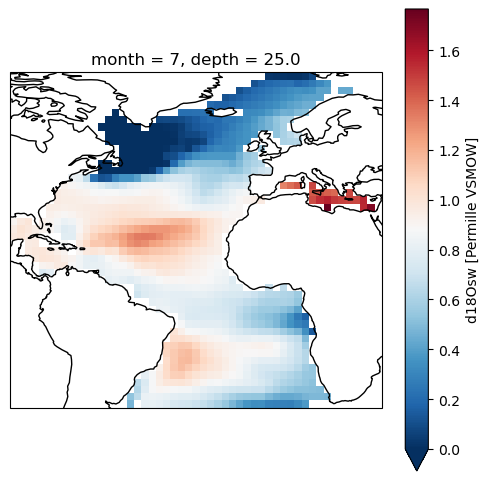

In [6]:
### run this code to check you've loaded the data properly 
# 
## use the .sel syntax to select data from the month of July and the 25m depth level
f = plt.figure(figsize=(6,6)) # initialise an empty figure
ax = f.add_subplot(111,projection=ccrs.PlateCarree())
ocean_data.sel(depth=25,month=7)['d18Osw'].plot(
    vmin=0, # set the minimum color as 0
    cmap='RdBu_r', # use a red and blue colormap
    ax=ax, # use the axis we made above
    transform=ccrs.PlateCarree() # set the map projection to use
)
ax.coastlines() # add coastlines for reference


## Task 2.2: write a function that samples the coean data at a given latitude and longitude


In [7]:
def sample_data(lat,lon,depth,month):
    """
    This function returns the temperature and d18O of seawater at given location (lat,lon) for a given month.
 
    Parameters:
    lat (float): latitude you want to sample (degrees north).
    lon (float): longitude you want to sample (degrees east).
    depth (float): water depth (m)
    month (int): indexer for the month you wants (1=jan,2=feb, etc)

    Returns:
    data_i: an xarray dataset of d18Osw and T at the given location
    """    

    data_i = ocean_data.sel(lat=lat,lon=lon,month=month,depth=depth,method='nearest').squeeze()
    return data_i



In [36]:
## test your function by running this cell with test values:
lat = 50 # 50ºN
lon = -20 # 20ºW
depth = 100 # depth of 100m
month = 6 # month of june

sample_data(lat,lon,depth,month)['T'].values

## the value it gives should be 10.15 degrees

array(10.14534923)

----
## Task 3: Foram ecology


In [31]:
### load the ecological mdoel data
foram_eco = xr.open_dataset('data/plafom_foram_abundance.nc') # don't change this!


### function
def find_preference(lat,lon,species):
    """
    This function finds the depth and month at which the species abundance is highest in the ecological model.

    Parameters:
    lat (float): latitude you want to sample (degrees north).
    lon (float): longitude you want to sample (degrees east).
    species (str): the species of interest, one of ['GBulloides','GRuberW','NPachyderma] 

    Returns:
    depth_pref (int): the preferred depth
    month_pref (str): the preferred month
    """
    if species not in ['GBulloides','GRuberW','NPachyderma']:
        raise SyntaxError('Sorry, we dont have that species!')
    else:
        df_ = foram_eco.sel(lat=lat,lon=lon,method='nearest')[species]
        month_pref = df_.where(df_ == df_.max(),drop=True).month.data[0]
        depth_pref = df_.where(df_ == df_.max(),drop=True).depth.data[0]

        return depth_pref, month_pref



(5.0, 'Sep')

In [34]:
### run this cell to check your functions works properly
lat = 50
lon = -20
species = 'GRuberW'

find_preference(lat,lon,species)

## the output should read (5 and 'Sep'), meaning G Ruber White preferrentially lives at 5m depth during September

(5.0, 'Sep')

----
## Task 4: Bringing it together!

_note: you should include an option to use different d18O calcite equation coefficients..._

Let the user inut one of the "Names" from the table below. The function should then assign a value to a, b, and c, depending on the equation chosen.

| Name | a    | b    | c    | ref                   | method                  |
|------|------|------|------|-----------------------|-------------------------|
| KO97 | 16.1 | 4.64 | 0.05 | Kim and O'Neil (1997) | Inorganic calcite (lab) |
| EL83 | 17.0 | 4.52 | 0.03 | Erez and Luz (1983)   | Cultured forams         |
| M02  | 14.3 | 4.34 | 0.09 | Mulitza et al., 2002  | Field calibration       |


In [44]:
## this function might help...
def monthToNum(shortMonth):
    """convert month string to integer"""
    return {
            'Jan': 1,
            'Feb': 2,
            'Mar': 3,
            'Apr': 4,
            'May': 5,
            'Jun': 6,
            'Jul': 7,
            'Aug': 8,
            'Sep': 9, 
            'Oct': 10,
            'Nov': 11,
            'Dec': 12
    }[shortMonth]

### your code here:
def d18o_forward_model(lat,lon,species,calibration='KO97'):

    depth, month = find_preference(lat,lon,species)
    month =monthToNum(month)

    data_i = sample_data(lat,lon,depth,month)

    if calibration == 'KO97':
        a = 16.1
        b = 4.64
        c = 0.05
    elif calibration == 'EL83':
        a = 17.0
        b = 4.52
        c = 0.03
    elif calibration == 'M02':
        a = 14.3
        b = 4.34
        c = 0.09

    d18o_predicted = equilibrium_calcite(data_i['d18Osw'],T=data_i['T'],a=a,b=b,c=c)

    return d18o_predicted



In [45]:
d18o_forward_model(50,-20,'GRuberW','KO97')

<xarray.DataArray ()> Size: 8B
array(-0.04942717)
Coordinates:
    month    int64 8B 9
    depth    float64 8B 25.0
    lat      float64 8B 50.0
    lon      float64 8B -20.0

Text(0.5, 1.0, 'N. pachyderma')

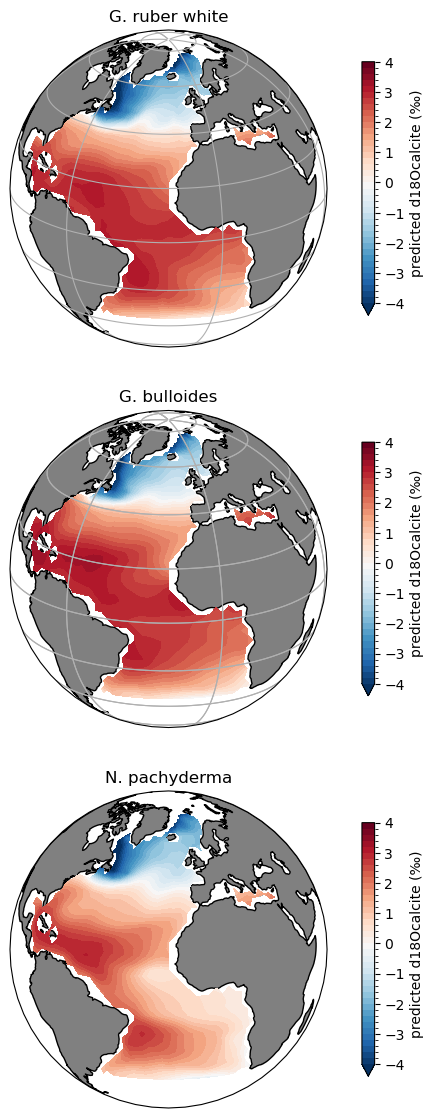

In [87]:
lat = ocean_data.lat
lon = ocean_data.lon

## plot predicted calcite d18O
f = plt.figure(figsize=(9,14))
mapproj  = ccrs.Orthographic(central_longitude=-20,central_latitude=20)

levels = np.arange(-4,4.2,0.2)
ax = f.add_subplot(311,projection=mapproj)
ax.add_feature(cartopy.feature.LAND, facecolor='grey',edgecolor='black')
d18o_forward_model(lat,lon,'GRuberW','KO97').plot.contourf(levels=levels,ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':0.8,'label':'predicted d18Ocalcite (‰)'})
gl = ax.gridlines(draw_labels=False,x_inline=False,y_inline=False, crs=ccrs.PlateCarree())
ax.set_global()
ax.set_title('G. ruber white')
ax2 = f.add_subplot(312,projection=mapproj)
ax2.add_feature(cartopy.feature.LAND, facecolor='grey',edgecolor='black')
d18o_forward_model(lat,lon,'GBulloides','KO97').plot.contourf(levels=levels,ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':0.8,'label':'predicted d18Ocalcite (‰)'})
gl = ax2.gridlines(draw_labels=False,x_inline=False,y_inline=False, crs=ccrs.PlateCarree())
ax2.set_global()
ax2.set_title('G. bulloides')

ax3 = f.add_subplot(313,projection=mapproj)
ax3.add_feature(cartopy.feature.LAND, facecolor='grey',edgecolor='black')
d18o_forward_model(lat,lon,'NPachyderma','KO97').plot.contourf(levels=levels,ax=ax3,transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':0.8,'label':'predicted d18Ocalcite (‰)'})
gl = ax2.gridlines(draw_labels=False,x_inline=False,y_inline=False, crs=ccrs.PlateCarree())
ax3.set_global()
ax3.set_title('N. pachyderma')